In [1]:
%matplotlib widget

import os
import sympy as sm
import scipy as sp
import numpy as np
import matplotlib as mpl
import matplotlib.ticker as ticker

from matplotlib import pyplot as plt
from mpl_styles import analytic
from scipy.special import hyp2f1
from sympy import init_printing, init_session

plt.style.use(analytic)
init_session()
init_printing()

def Pochhammer(a, k):
    if k == 0:
        return 1.0
    else:
        return (a + k - 1) * Pochhammer(a, k - 1)


def b(s, j, alpha):
    if j >= 0:  # Eq. 7.87
        return (
            2
            * Pochhammer(s, j)
            / Pochhammer(1, j)
            * (alpha**j)
            * hyp2f1(s, s + j, j + 1, alpha * alpha)
        )
    else:  # Eq. 6.69
        return b(s, -j, alpha)


def Db(s, j, alpha):  # Eq. 6.70
    aux = (
        b(s + 1, j - 1, alpha) - 2 * alpha * b(s + 1, j, alpha) + b(s + 1, j + 1, alpha)
    )
    return s * aux


def D2b(s, j, alpha):  # Eq. 6.71
    aux = (
        Db(s + 1, j - 1, alpha)
        - 2 * alpha * Db(s + 1, j, alpha)
        - 2 * b(s + 1, j, alpha)
        + Db(s + 1, j + 1, alpha)
    )
    return s * aux


def f27lc(alpha, j):
    """
    f27 in MD p543
    (1/2)[−2 j − αD] b^(j)_{1/2}(α) x [e1cos(theta1)]
    """
    return 0.5 * (-2 * (j + 1) * b(0.5, j + 1, alpha) - alpha * Db(0.5, j + 1, alpha))


def f31lc(alpha, j):
    """
    f31 in MD p543
    (1/2)[−1 + 2 j + αD] b^(j-1)_{1/2}(α) x [e2cos(theta2)]
    """
    return 0.5 * ((-1 + 2 * (j + 1)) * b(0.5, j, alpha) + alpha * Db(0.5, j, alpha))

alpha0 = (2 / (2 + 1)) ** (2.0 / 3)

############################################################
# If test particle is outside, have to multiply by alpha_0 #
############################################################

f1val_outside = alpha0*f27lc(alpha0, 2)
f2val_outside = alpha0*f31lc(alpha0, 2)

IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



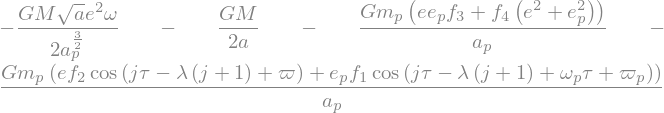

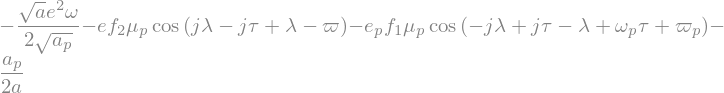

In [2]:
f1, f2, f3, f4, tau, l, pom, pom_p, g, om, om_p = sm.symbols(
    "f_1 f_2 f_3 f_4 tau lambda varpi varpi_p gamma omega omega_p"
)
a, a_p, e, e_p, n, n_p, m_p, mu_p, L, G, Gconst, M, j = sm.symbols(
    "a a_p e e_p n n_p m_p mu_p Lambda Gamma G M j", positive=True
)
X, Y, Te, Tm = sm.symbols("X Y T_e T_m")

H_scale_factor = Gconst * M / a_p
t_scale_factor = sqrt(Gconst * M / a_p**3)  # = n_p
L_scale_factor = H_scale_factor / t_scale_factor

calH = (
    -(Gconst * M) / (2 * a)
    - Gconst
    * m_p
    / a_p
    * (
        e * f2 * sm.cos((j + 1) * l - j * tau - pom)
        + e_p * f1 * sm.cos((j + 1) * l - j * tau - pom_p - om_p * tau)
    )
    - (Gconst * m_p / a_p * (f3 * e * e_p + f4 * (e**2 + e_p**2)))
    - Rational(1, 2) * sqrt(Gconst * M * a) * e**2 * om * t_scale_factor
)


display(calH)
calH = (
    (calH / H_scale_factor)
    .subs(m_p, mu_p * M)
    .simplify()
    .expand()
    .subs({f3: 0, f4: 0})
    #.subs(a, a * a_p)
)
display(calH)

In [3]:
def to_canonical(expr):
    return expr.subs({a: L**2, e: sqrt(2 * G / L), pom: -g})


def to_orbelts(expr):
    # This uses the approximation G=1/2*L*e^2
    return expr.subs({g: -pom, G: Rational(1, 2) * L * e**2, L: sqrt(a)})

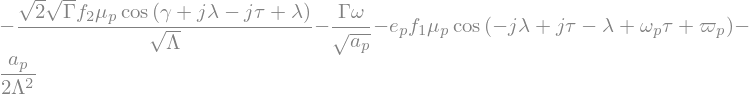

In [4]:
Hcanon = to_canonical(calH)
Hcanon

In [5]:
x = Matrix([l,g,L,G])
x

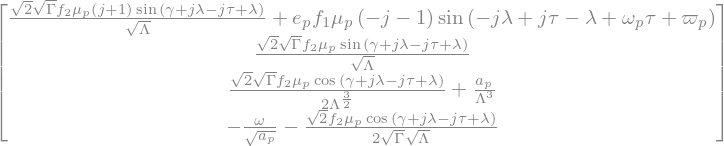

In [6]:
pHpx = Matrix([Hcanon]).jacobian(x).T
pHpx

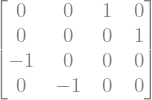

In [7]:
J = Matrix(BlockMatrix([[zeros(2,2),eye(2)],[-eye(2),zeros(2,2)]]))
J

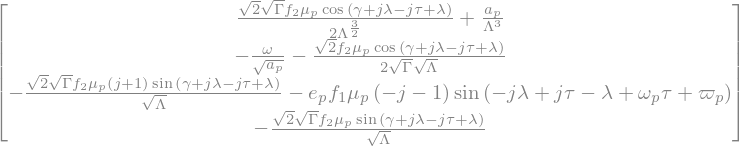

In [8]:
dxdt = J*pHpx
dxdt

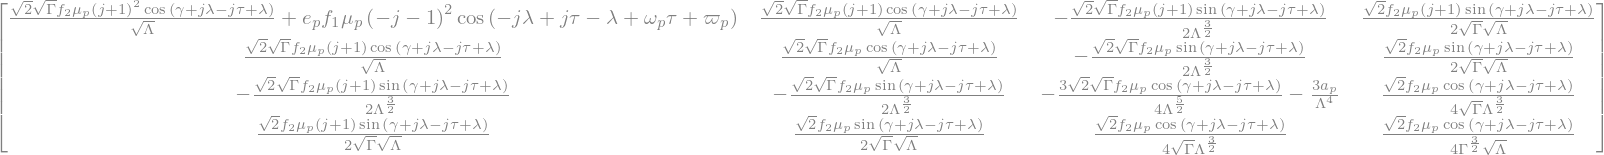

In [9]:
p2Hpx2 = pHpx.jacobian(x)
p2Hpx2

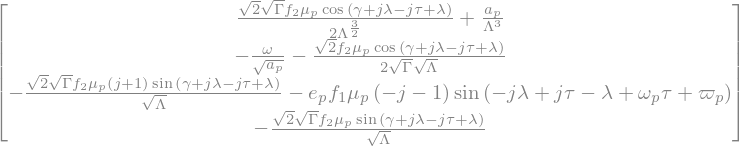

In [10]:
dxdt

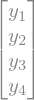

In [11]:
y1, y2, y3, y4 = sm.symbols("y_1 y_2 y_3 y_4")
y = Matrix([y1, y2, y3, y4])
y

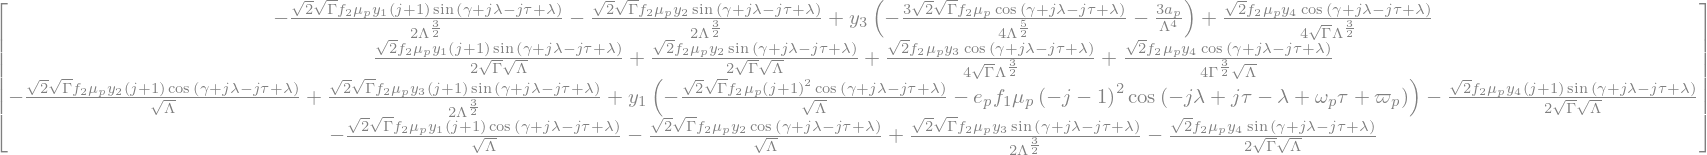

In [12]:
dydt = J*p2Hpx2*y
dydt

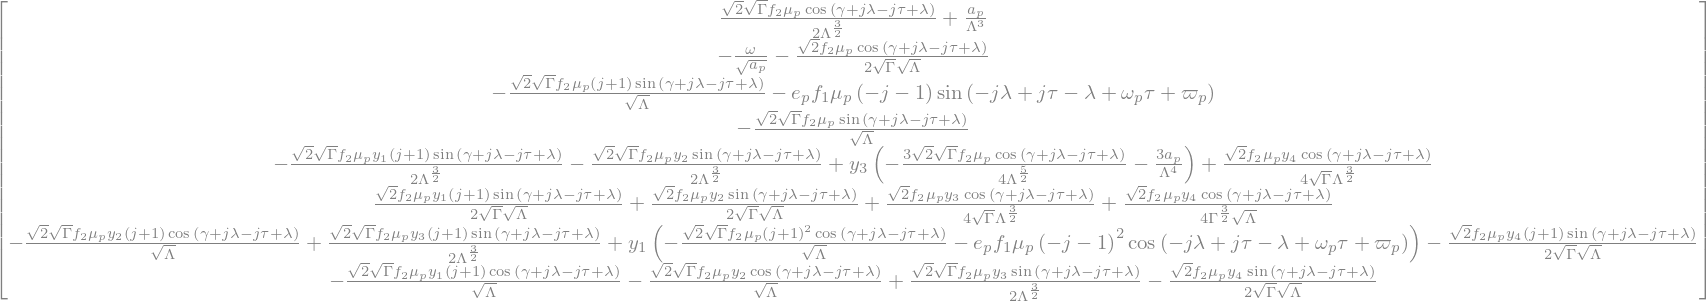

In [13]:
RHS = Matrix.vstack(dxdt, dydt)
RHS

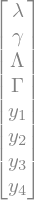

In [14]:
xy = Matrix([l,g,L,G,y1,y2,y3,y4])
xy

# Single runs

In [15]:
params = {
    a_p:1,
    e_p:0.1,
    mu_p:3e-6,
    pom_p:0,
    om:0,
    om_p:0,
    f1:f1val_outside,
    f2:f2val_outside,
    j:2,
}
rhs = RHS.subs(params)
rhs.free_symbols

In [16]:
rhs.free_symbols

In [17]:
rhsfunc = lambdify([tau,*xy],rhs)

In [18]:
def func(t, Y):
    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7])[:,0]


In [19]:
initorb = {
    a:1.31,
    e:0.04,
    pom:0,
    l:np.pi/3
}
initcanon = {
    l:to_orbelts(l).subs(initorb),
    g:to_orbelts(g).subs(initorb),
    L:to_orbelts(L).subs(initorb),
    G:to_orbelts(G).subs(initorb),
    tau:0,
}
initcanon

In [20]:
rhsfunc

<function _lambdifygenerated(tau, lambda_, gamma, Lambda, Gamma, y_1, y_2, y_3, y_4)>

In [21]:
#inity = dxdt.subs(params).subs(initcanon).subs({}).evalf()
#inity = inity/sqrt((inity.T*inity)[0]) # normalize
inity = [0,0,0,1]
inity = {y[i]:el for i, el in enumerate(inity)}
inity

In [22]:
def func(t, Y):
    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7])[:,0]


Y0 = np.float64(xy.subs(initcanon).subs(inity))[:,0]
Y0

array([1.04719755e+00, 0.00000000e+00, 1.14455231e+00, 9.15641851e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00])

In [23]:
func(0,Y0).shape

In [24]:
#%%timeit
t_span = (0,10000)
sol = sp.integrate.solve_ivp(func, t_span, Y0, t_eval=np.linspace(*t_span,1000))

In [25]:
dx_t = sol.y[4:,:]
dx_t.shape

In [ ]:
fig, ax = plt.subplots()
ax.plot(sol.t,np.log(np.linalg.norm(dx_t[:,:],axis=0)))

In [123]:
#%%timeit
sol = []
#for inity in [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]:
for inity in [[0,0,0,1]]:
    inity = {y[i]:el for i, el in enumerate(inity)}
    Y0 = np.float64(xy.subs(initcanon).subs(inity))[:,0]

    t_span = (0,10000)
    sol += [sp.integrate.solve_ivp(func, t_span, Y0, t_eval=np.linspace(*t_span,1000),rtol=1e-9)]

In [ ]:
fig, ax = plt.subplots()
for s in sol:
    dx_t = s.y[4:,:]
    ax.plot(s.t,np.log(np.linalg.norm(dx_t[:,:],axis=0)))

# Grid of runs

In [19]:
params = {
    a_p:1,
    e_p:0.03,
    mu_p:1e-3,
    pom_p:0,
    om:0,
    om_p:0,
    f1:f1val_outside,
    f2:f2val_outside,
    j:2,
}
rhs = RHS.subs(params)
rhs.free_symbols
rhsfunc = lambdify([tau,*xy],rhs)
def func(t, Y):
    return rhsfunc(t, Y[0], Y[1], Y[2], Y[3], Y[4], Y[5], Y[6], Y[7])[:,0]

In [27]:
def calc_FLIt(i, av, th2v):
    print(i)
    initorb = {
        a:av,
        e:0.03,
        pom:0,
        l:th2v/(params[j]+1)
    }
    initcanon = {
        l:to_orbelts(l).subs(initorb),
        g:to_orbelts(g).subs(initorb),
        L:to_orbelts(L).subs(initorb),
        G:to_orbelts(G).subs(initorb),
        tau:0,
    }
    inity = [0,0,0,1]
    inity = {y[i]:el for i, el in enumerate(inity)}

    Y0 = np.float64(xy.subs(initcanon).subs(inity))[:,0]
    t_span = (0,1e4)
    sol = sp.integrate.solve_ivp(func, t_span, Y0, t_eval=np.linspace(*t_span,1000))
    dx_t = sol.y[4:,:]
    return(np.log(np.linalg.norm(dx_t[:,:],axis=0)[-1]))

In [28]:
calc_FLIt(0, 1.31, 0)

0


<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in sqrt
  return array([[0.000947825370634774*sqrt(2)*sqrt(Gamma)*cos(gamma + 3*lambda_ - 2*tau)/Lambda**(3/2) + Lambda**(-3.0)], [-0.000947825370634774*sqrt(2)*cos(gamma + 3*lambda_ - 2*tau)/(sqrt(Gamma)*sqrt(Lambda))], [-0.00568695222380864*sqrt(2)*sqrt(Gamma)*sin(gamma + 3*lambda_ - 2*tau)/sqrt(Lambda) + 0.000139098075450893*sin(3*lambda_ - 2*tau)], [-0.00189565074126955*sqrt(2)*sqrt(Gamma)*sin(gamma + 3*lambda_ - 2*tau)/sqrt(Lambda)], [-0.00284347611190432*sqrt(2)*sqrt(Gamma)*y_1*sin(gamma + 3*lambda_ - 2*tau)/Lambda**(3/2) - 0.000947825370634774*sqrt(2)*sqrt(Gamma)*y_2*sin(gamma + 3*lambda_ - 2*tau)/Lambda**(3/2) + y_3*(-0.00142173805595216*sqrt(2)*sqrt(Gamma)*cos(gamma + 3*lambda_ - 2*tau)/Lambda**(5/2) - 3/Lambda**4) + 0.000473912685317387*sqrt(2)*y_4*cos(gamma + 3*lambda_ - 2*tau)/(sqrt(Gamma)*Lambda**(3/2))], [0.00284347611190432*sqrt(2)*y_1*sin(gamma + 3*lambda_ - 2*tau)/(sqrt(Gamma)*sqrt(Lambda)) + 0.00094782

In [32]:
(1.5)**(2./3)*1.1

In [33]:
jobs = []
TH2V, AV = np.meshgrid(np.linspace(0,2*np.pi,300), np.linspace(1.18,1.44,300))
for ii in range(len(TH2V.flatten())):
    jobs = jobs + [(ii,TH2V.flatten()[ii],AV.flatten()[ii])]

In [37]:
len(jobs)*.3/3600/60